Quick script to analyze basic properties of the mmgel equilibration phase such as:
- mmgel shape and size
- MNP positions and distance from mmgel CoM
- number of loaded MNPs

In [1]:
import sys

sys.path.append("../")

/Users/r/Documents/work/icp/microgel/code


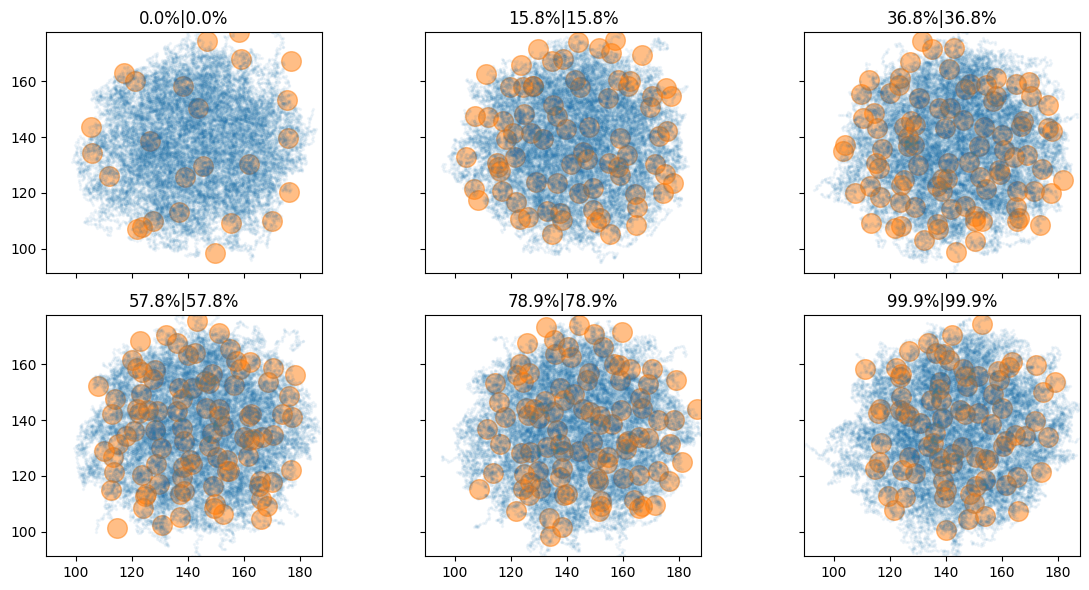

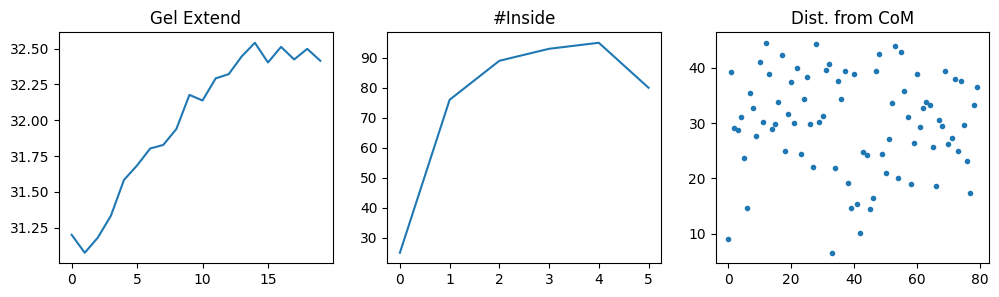

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
from scipy.spatial import Delaunay

def check_points_inside_convex_hull(points, mnp_points):
    """
    Checks which mnp_points are inside the convex hull of points.
    
    Args:
        points (np.ndarray): Array of shape (N, 3) representing the point cloud.
        mnp_points (np.ndarray): Array of shape (M, 3) representing the points to check.
        
    Returns:
        np.ndarray: A boolean array of shape (M,) where True means the point is inside the convex hull.
    """
    hull = Delaunay(points)
    return hull.find_simplex(mnp_points) >= 0

data_dir = Path("../../tmp_data/mmgel_full_duration")
assert data_dir.exists(), data_dir.resolve()

def get_index(p: Path) -> int:
    return int(p.stem.split("_")[1])


def extend(p: Path):
    from analysis import form
    assert isinstance(p, Path)
    return form.HydroRadiusComputer.process_file(p)[1]


files = np.array(sorted(data_dir.glob("BeadPos_*.npy"), key=get_index))
assert len(files) > 0, len(files)
extends = np.array([extend(p) for p in files])

N_PLOTS = min(len(files), 6)
file_indices = np.linspace(0, len(files) - 1, N_PLOTS, endpoint=True, dtype=int)
files = files[file_indices]
indices = sorted(map(get_index, files))
mnp_files = np.array([data_dir / f"MNPPos_{i}.npy" for i in indices])
assert np.all([p.exists() for p in mnp_files])
assert len(files) == len(mnp_files)


s_points = 2
diameter_ratio = 10 / 1 # 10 times larger
s_mnp = s_points * (diameter_ratio**2) # 1 * (10**2) = 100


ncols=3
nrows=int(np.ceil(N_PLOTS / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
axs = axs.flat
is_mnp_inside = []
for ax, file, mnp_file in zip(axs, files, mnp_files):
    points = np.load(file)
    mnp_points = np.load(mnp_file)
    is_mnp_inside.append(check_points_inside_convex_hull(points, mnp_points))
    ax.scatter(*points[:, :2].T, s=s_points, alpha=0.05)
    ax.scatter(*mnp_points[is_mnp_inside[-1], :2].T, s=s_mnp, alpha=0.5, zorder=-10)
    ax.set_xlim(np.min(points[:, 0]), np.max(points[:, 0]))
    ax.set_ylim(np.min(points[:, 1]), np.max(points[:, 1]))
    ax.set_aspect('equal', adjustable='box')
    # ax.set_xlim(0,280)
    # ax.set_ylim(0,280)
    ax.set_title(f"{get_index(file)/1e7:.1%}|{get_index(mnp_file)/1e7:.1%}")
plt.tight_layout()
plt.show()


def dist_from_com(i: int):
    points = np.load(files[i])
    mnp_points = np.load(mnp_files[i])
    com = np.mean(points, axis=0)
    distances = np.linalg.norm(mnp_points[is_mnp_inside[i]] - com, axis=1)
    return distances


fig, axs = plt.subplots(ncols=3, figsize=(12, 3))
axs[0].plot(extends)
axs[0].set_title("Gel Extend")
axs[1].plot([np.count_nonzero(a) for a in is_mnp_inside])
axs[1].set_title("#Inside")
axs[2].plot(dist_from_com(len(files) - 1), ".")
axs[2].set_title("Dist. from CoM")
# axs[2].plot([dist_from_com(i) for i in range(len(files))], ".")
plt.show()